# ML-BPMN Getting Started with scikit-learn

*... a tutorial for students in the FHNW, written by [Andreas Martin, PhD](https://andreasmartin.ch).*

|[![deepnote](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?url=https%3A%2F%2Fgithub.com%2FAI4BP%2Fainotes%2Fblob%2Fmain%2Fipynb%2Fexpense-authorization-process%2Fexpense-authorization.ipynb)|[![Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AI4BP/ainotes/blob/main/ipynb/expense-authorization-process/expense-authorization.ipynb)|[![Gitpod](https://img.shields.io/badge/Gitpod-Run%20in%20VS%20Code-908a85?logo=gitpod)](https://gitpod.io/#https://github.com/AI4BP/ainotes/)|[![GitHub.dev](https://img.shields.io/badge/github.dev-Open%20in%20VS%20Code-908a85?logo=github)](https://github.dev/AI4BP/ainotes/blob/main/ipynb/expense-authorization-process/expense-authorization.ipynb)|
|-|-|-|-|

This short tutorial is intended to provide a straight forward introduction to machine learning using the widely used Python library **scikit-learn** (aka sklearn).

> Trivia: The name *SciKit* is derived from its original intention being a SciPy Toolkit. SciPy is another Python library for scientific computing.

Sklearn enjoys huge popularity when it comes to classic machine learning methods; it is well documented, has a large developer community and besides the official documentation there are plenty of other good resources for the ML toolkit available on the web.

> Sklearn is intended for **classical ML** and **not for Deep Learning**, although a Multi-layer Perceptron (MLP), for example, can be trained. Since Sklearn does **not support GPUs**, it is not suitable for large-scale applications.

## Data and Use Case
This tutorial uses historical data from an expense reporting and audit process — the **expense authorization process** is depicted in the following Fig a:

![](https://github.com/AI4BP/ainotes/raw/main/sklearn-getting-started/ipynb/images/expense-authorization-sklearn.png)

**Fig a**: expense authorization process

This (possibly synthetic) data was collected by humans, which is approved or not based on the expense **category**, **urgency**, **target price** and actual **price** paid.

> This use case has been inspired by an example/article of Donato Marrazzo (Red Hat, Inc.). He provided data, in a related GitHub repository [[1]](https://github.com/dmarrazzo/rhdm-dmn-pmml-order), of an **expense approval process**, which is used here in this tutorial, along with a series of articles ([[2]](https://developers.redhat.com/blog/2021/01/14/knowledge-meets-machine-learning-for-smarter-decisions-part-1#conclusion) and [[3]](https://developers.redhat.com/blog/2021/01/22/knowledge-meets-machine-learning-for-smarter-decisions-part-2#conclusion)).

### 🚧 Main Task
The task in this tutorial is to train an ML model step by step.

## 0. Initialization Configuration
In the following there is some code for initialization. For example, the URL to the data `url_data` and the BPMN/DMN models `url_modelling` is set.

In [1]:
import os

url_github = "https://raw.githubusercontent.com/AI4BP/ainotes/main"
project_folder = "sklearn-getting-started"
working_dir = os.path.normpath(os.getcwd()+"/../")
url_data = "data"
url_data = f"{working_dir}/{url_data}" if os.path.exists(f"{working_dir}/{url_data}") else f"{url_github}/{project_folder}/{url_data}"
print(url_data)
url_modelling = "modelling"
url_modelling = f"{working_dir}/{url_modelling}" if os.path.exists(f"{working_dir}/{url_modelling}") else f"{url_github}/{project_folder}/{url_modelling}"
print(url_modelling)

/work/sklearn-getting-started/data
/work/sklearn-getting-started/modelling


## 1. Load the CSV File
Load the CSV file from GitHub and feed the data into the *data* variable by using [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). Pandas is intended to be a data analysis and manipulation tool, which is used here and the following steps until dataset separation.

In [2]:
import pandas

data = pandas.read_csv(f"{url_data}/expense-authorization.csv", sep=",")

data

,category,urgency,targetPrice,price,approved
0,basic,medium,790,837,True
1,basic,high,1250,1734,False
2,optional,low,670,944,False
3,basic,medium,1550,1728,True
4,optional,medium,630,988,False
...,...,...,...,...,...
3995,basic,high,580,903,False
3996,basic,high,2950,3063,True
3997,basic,low,1600,1601,True
3998,basic,high,1890,1994,True


## 2. Map Categories to Numbers
If we investigate the output of the loaded data in the previous step, we see, that **category** and **urgency** are some categorical strings. To feed that data into our ML model, we need to convert and map the categorical strings to numbers. So we map...: 
- category *optional* to 0
- category *basic* to 1
- urgency *low* to 0
- urgency *medium* to 1
- urgency *high* to 2

In [3]:
category = {"optional": 0, "basic": 1}
data.category = [category[item] for item in data.category]
urgency = {"low": 0, "medium": 1, "high": 2}
data.urgency = [urgency[item] for item in data.urgency]

data

,category,urgency,targetPrice,price,approved
0,1,1,790,837,True
1,1,2,1250,1734,False
2,0,0,670,944,False
3,1,1,1550,1728,True
4,0,1,630,988,False
...,...,...,...,...,...
3995,1,2,580,903,False
3996,1,2,2950,3063,True
3997,1,0,1600,1601,True
3998,1,2,1890,1994,True


## 3. Data Segregation and Feature Selection
If we investigate the output of the mapped data in the previous step, we see, that we have **category**, **urgency**, **target price** and actual **price** features with "input" data, or in ML terminology **samples/design matrix** usually denoted as **X**.

The **approved** column is the "output or decision" data, or in ML terminology the **target values** denoted as **y**.

For further processing, we need to segregate **X** and **y** as follows.

In [4]:
X_data = data.drop("approved", axis=1)
y_data = data.approved

print("X Data:\n", X_data)
print("y Data:\n", y_data)

X Data:
       category  urgency  targetPrice  price
0            1        1          790    837
1            1        2         1250   1734
2            0        0          670    944
3            1        1         1550   1728
4            0        1          630    988
...        ...      ...          ...    ...
3995         1        2          580    903
3996         1        2         2950   3063
3997         1        0         1600   1601
3998         1        2         1890   1994
3999         1        0         2540   2921

[4000 rows x 4 columns]
y Data:
 0        True
1       False
2       False
3        True
4       False
        ...  
3995    False
3996     True
3997     True
3998     True
3999    False
Name: approved, Length: 4000, dtype: bool


## 4. Data Partitioning
Training or, in ML terminology, fitting a model to data, does not mean that it will produce acceptable predictions on new data. Therefore, we split / partition the data set into a training and a testing set to be able to evaluate the performance. To accomplish this, the function [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) of scikit-learn can be used.
- In the following, we slit the X and y data sets by 60% training and 40% testing sets defined by the `test_size=0.40` parameter.
- The `random_state=` parameter can be adjusted from `none` to an *int* value for a reproducible output across multiple executions.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.40, random_state=None
)

print("X_train:\n", X_train)
print("y_train:\n", y_train)
print("X_test:\n", X_test)
print("y_test:\n", y_test)

X_train:
       category  urgency  targetPrice  price
1320         1        2         2090   2196
3194         1        1          120    424
2613         0        0          200    557
2812         1        0          760   1258
3524         1        0         2350   2771
...        ...      ...          ...    ...
2720         0        2         2960   3133
934          1        2          430    864
54           1        0         3180   3647
3420         0        0         2680   2879
526          0        0         1220   1559

[2400 rows x 4 columns]
y_train:
 1320     True
3194    False
2613    False
2812    False
3524    False
        ...  
2720     True
934     False
54       True
3420     True
526     False
Name: approved, Length: 2400, dtype: bool
X_test:
       category  urgency  targetPrice  price
2813         1        1           60    221
324          0        1         1360   1851
48           0        0         2260   2639
3629         0        2         2570   2627
18

### 🚧 Supplementary Tasks
1. Try to adjust the split parameter `test_size=`, e.g., 80/20, 70/30, 75/25 or even 50/50.
2. Investigate what happens when the `random_state=` parameter is, e.g., `0`.

## 5. Initialize Learner
Now we are going to initialize the learner for our classification problem. Sklearn provides a vide range of models for supervised and unsupervised learning. Andre Ye (2021) has provided on [Medium, towards data science,](https://towardsdatascience.com/your-ultimate-data-mining-machine-learning-cheat-sheet-9fce3fa16) a nice cheat-sheet for sklearn which can be recommended for further reading. From him, the following Fig 5a has been taken, showcasing a subset of the most important classifiers in sklearn.

![](https://github.com/AI4BP/ainotes/raw/main/sklearn-getting-started/ipynb/images/sklearn%20classifier%20models%20Ye%2C%202021.png)

**Fig 5a**: sklearn classifier models ([Ye, 2021](https://towardsdatascience.com/your-ultimate-data-mining-machine-learning-cheat-sheet-9fce3fa16))

### Logistic Regression

Our default model in this tutorial will be a linear model called `LogisticRegression`. Even if the name suggests otherwise, this is a linear model for classification rather than regression.

> Classification vs. regression: **classification** is about predicting an assignment to a **class**, whereas **regression** is about predicting a certain **score**. 

So we are going to initialize a logistic regression (logit) model from scikit-learn by importing and using [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with the following parameters:
- `max_iter=1000` defines the maximum number of iterations taken for the solvers to converge.
- `multi_class='auto'` is automatically selecting an appropriate approach; in binary situations, it uses the one-vs-rest (OvR) approach.


In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, multi_class="auto")

print("Model: ", model)

Model:  LogisticRegression(max_iter=1000)


### 🚧 Supplementary Tasks
Try to experiment with other classification models from sklearn as well (you have to uncomment it):

In [7]:
# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier()

In [8]:
# from sklearn.svm import SVC
# model = SVC()

In [9]:
# from sklearn.naive_bayes import GaussianNB
# model = GaussianNB()

In [10]:
# from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier()

> ‼️ You can only initialize one model per run of the pipeline.

## 6. Tune Class Weights
The author, Donato Marrazzo (Red Hat, Inc.), of the article ([[2]](https://developers.redhat.com/blog/2021/01/14/knowledge-meets-machine-learning-for-smarter-decisions-part-1#conclusion)) from which this dataset is from had an interesting idea. It maybe would be better to reject a correct expense claim than to accept an incorrect one, as rejected expense claims can be re-verified by humans. Therefore, one could try to reduce the weight of accepted expense claims.

Therefore, it might be worth considering setting the weight of rejected (`False`) claims to 100% (`False : 1.0`) and that of accepted (`True`) cases to about 65% (`True : 0.65`).


In [11]:
model.class_weight = {False: 1.0, True: 0.65}

print("Model: ", model)

Model:  LogisticRegression(class_weight={False: 1.0, True: 0.65}, max_iter=1000)


### 🚧 Supplementary Tasks

Try experimenting with other weight values assigned by hand as well.

Further on, we can do some cross-validation and grid search to find the best class weight in the following.

In [12]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import is_multilabel

weights = np.linspace(0.0, 0.99, 25)
class_weight = {
    "class_weight": [{len(np.unique(y_data)) - 1: 1.0 - x} for x in weights]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=class_weight, #accuracy #f1_micro roc_auc_ovr roc_auc_ovo roc_auc_ovo_weighted
    scoring="roc_auc" if is_multilabel(y_data) else "f1_micro", #average_precision #precision #roc_auc
    n_jobs=-1,
    cv=5,
    verbose=2,
)

grid.fit(X_train, y_train)

print(f"Class weight: {grid.best_params_['class_weight']}")
print(f"ROC AUC score: {grid.best_score_}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..............................class_weight={1: 1.0}; total time=   0.0s
[CV] END ..............................class_weight={1: 1.0}; total time=   0.0s
[CV] END ..............................class_weight={1: 1.0}; total time=   0.0s
[CV] END ..............................class_weight={1: 1.0}; total time=   0.0s
[CV] END ..............................class_weight={1: 1.0}; total time=   0.0s
[CV] END ..........................class_weight={1: 0.95875}; total time=   0.0s
[CV] END ..........................class_weight={1: 0.95875}; total time=   0.0s
[CV] END ..........................class_weight={1: 0.95875}; total time=   0.0s
[CV] END ..........................class_weight={1: 0.95875}; total time=   0.0s
[CV] END ..........................class_weight={1: 0.95875}; total time=   0.0s
[CV] END ...........................class_weight={1: 0.9175}; total time=   0.0s
[CV] END ...........................class_weigh

First, we generate some possible weights in a linear matter and map the weights to classes. Then we perform a grid search and use a `roc_auc` strategy (in binary situations; if multi label e.g. `f1_micro`) to evaluate the performance of the cross-validated model.

> What is the `roc_auc` score/strategy? The receiver operator characteristic (ROC) curve is a probability curve for binary classification problems that scores the true positives (TP) against the false positives (FP). The higher the score of the area under the curve (AUC), the better the performance of the estimator. More about TP and FP can be read in Section 9.2.

## 7. Train Model
Now we can train the configured model on the training set by using the sklearn `fit` method.

In [13]:
model.fit(X_train, y_train)

LogisticRegression(class_weight={False: 1.0, True: 0.65}, max_iter=1000)

## 8. Make Predictions

After training, we can use our testing set to make predictions by using the `predict` method sklearn. With the prediction, we can now retrieve and calculate performance metrics.

In [14]:
y_pred = model.predict(X_test)

print("Predictions (y): ", y_pred)

Predictions (y):  [False False False ... False False  True]


## 9. Scoring
Using various scoring metrics, we can examine how well the trained model performs on the test set.

### 9.1 Precision, Recall, F1 and Accuracy
In the following, multiple methods of sklearn are used to get overall precision, recall, F1 and overall accuracy.


> In a binary classification, the precision indicates the ratio of correctly predicted positive results (TP) in relation to the total of all results predicted as positive (TP + FP). The recall indicates the ratio of results correctly classified as positive (TP) in relation to the total of actually positive results (TP + FN).


> In general, the F1 score is the mean of precision and recall. The accuracy score assesses the accuracy of the correct predictions.

In [15]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

average_parameter="weighted" if is_multilabel(y_data) else "binary"

PS = precision_score(y_test, y_pred, average=average_parameter)
print(f"Precision Score (PS): {100 * PS:.2f}%")

RS = recall_score(y_test, y_pred, average=average_parameter)
print(f"Recall Score (RS): {100 * RS:.2f}%")

F1 = f1_score(y_test, y_pred, average=average_parameter)
print(f"F1: {100 * F1:.2f}%")

AS = accuracy_score(y_test, y_pred)
print(f"Accuracy Score (AS): {100 * AS:.2f}%")

Precision Score (PS): 95.77%
Recall Score (RS): 93.84%
F1: 94.79%
Accuracy Score (AS): 94.56%


In the following, a classification report can be generated by using the `classification_report` method of sklearn to get precision, recall and F1 on each class or label.

In [16]:
from sklearn.metrics import classification_report

CR = classification_report(y_test, y_pred)

print("Classification Report (CR):\n", CR)

Classification Report (CR):
               precision    recall  f1-score   support

       False       0.93      0.95      0.94       756
        True       0.96      0.94      0.95       844

    accuracy                           0.95      1600
   macro avg       0.95      0.95      0.95      1600
weighted avg       0.95      0.95      0.95      1600



### 9.2 Confusion Matrix
In the following, a confusion matrix can be generated by using the `confusion_matrix` method of sklearn.

> In binary classification problems, the confusion matrix consists of the number of true positive (TP), true negative (TN), false positive (FP) and false negative (FN) predictions.

In [17]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, y_pred)

print("Confusion Matrix (CM):\n", CM)

Confusion Matrix (CM):
 [[721  35]
 [ 52 792]]


The generated confusion matrix can be plotted with `ConfusionMatrixDisplay` of sklearn.

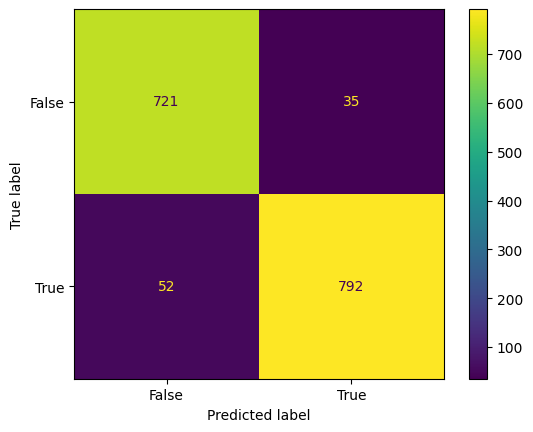

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=model.classes_)
disp.plot(values_format="")
plt.show()

#### Interpreting the Confusion Matrix
In a binary classification problem (as it is the case in this application scenario), one can interpret the plot as follows:
- Top-right: Number of cases where they actually not have a true label and the true label was predicted. So it is (**FP**) **F**alse that it is true (**P**ositive). In our case, we must minimize this!
- Bottom-left: Number of cases where they actually have a true label and the true label was not predicted. So it is (**FN**) **F**alse that it is false (**N**egative). In our case, we maybe can minimize this.
- Top-left: Number of cases where they actually not have a true label and the true label was not predicted. So it is (**TN**) **T**rue that it is false (**N**egative).
- Bottom-right: Number of cases where they actually have the true label and the true label was predicted. So it is (**TP**) **T**rue that it is true (**P**ositive).

## 10. Model Persistence
Finally, after training a model, we would save the model for future use so that it does not need to be trained again. Therefore, we now export the trained model with the library [Joblib](https://joblib.readthedocs.io/en/latest/persistence.html).

In [19]:
from joblib import dump

dump(model, f"{working_dir}/generated/expense-authorization.joblib")

['/work/sklearn-getting-started/generated/expense-authorization.joblib']

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0fd9439-c605-456d-a503-a84c619fa8f8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>